In [1]:
!pip3 install -q pybind11
!pip uninstall -q --yes gdown
!pip install -q gdown -U --no-cache-dir
!pip3 install -q --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git

     |████████████████████████████████| 222 kB 7.2 MB/s 


In [2]:
!git clone https://github.com/Edyarich/dlsystems-final-project
%cd dlsystems-final-project
!git checkout testing
!make

Cloning into 'dlsystems-final-project'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 381 (delta 154), reused 313 (delta 95), pack-reused 0
Receiving objects: 100% (381/381), 8.86 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (154/154), done.
/content/dlsystems-final-project
Branch 'testing' set up to track remote branch 'testing' from 'origin'.
Switched to a new branch 'testing'
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- F

In [3]:
import sys
sys.path.append('./python')

In [4]:
# Download the datasets you will be using for this project
import os
import gdown
import importlib
from data.utils import rename_and_filter_images
import urllib.request


%cd ./data
DIRNAME = './landscapes/'

if not os.path.exists(DIRNAME):
    !gdown 14g49ILtIYKLt7WXaRPYyVfJGLHxcnQ7s
    !unzip -q landscapes -d landscapes
    !rm landscapes.zip

    rename_and_filter_images(DIRNAME)

%cd ../

/home/eduard/git/dlsystems-final-project/data
/home/eduard/git/dlsystems-final-project


In [5]:
import needle as ndl
import needle.nn as nn
from needle import array_api, Tensor, NDArray
from apps.diffusion import Unet, Diffusion

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

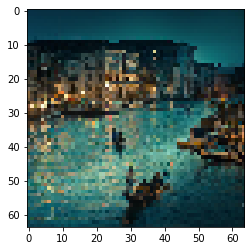

In [6]:
from pathlib import Path
from needle.autograd import Tensor


def plot_landscape(img):
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img);


DATA_DIR = Path('./data/landscapes/')
IMAGE_FILES = sorted(str(x) for x in list(DATA_DIR.rglob('*.jpg')))

transforms = [
    ndl.data.RandomFlipHorizontal(),
    ndl.data.Lambda(lambda img: np.transpose(img, (2, 0, 1))),
]

dataset = ndl.data.LandscapesDataset(
    IMAGE_FILES, extra_transforms=transforms, img_size=64
)
plot_landscape(dataset[1])

In [7]:
device = ndl.cpu()
model = Unet(device=device)
optimizer = ndl.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
timesteps = 300
module = Diffusion(model, timesteps, loss_type="l2", device=device)

In [9]:
epochs = 1
batch_size = 12
dataloader = ndl.data.DataLoader(dataset, batch_size)

In [13]:
for epoch in range(epochs):
    for step, batch in enumerate(tqdm(dataloader)):
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        optimizer.reset_grad()
        batch = ndl.Tensor(batch, device=device)
        t = Tensor(np.random.randint(0, timesteps, (len(batch),)),
                   device=device,
                   requires_grad=False)

        loss = module.p_losses(batch, t)

        if step % 100 == 0:
            print("Loss:", loss.cached_data[0])

        loss.backward()
        optimizer.step()

  0%|          | 0/360 [00:00<?, ?it/s]

Loss: [1.0858196]


  2%|▎         | 9/360 [00:22<14:20,  2.45s/it]


RuntimeError: ignored